<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/350_normal_normal_mod.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bayes-one-mean-notebook)=
# Inferenza bayesiana su una media

L'obiettivo principale di questo capitolo è esaminare un contesto che abbiamo già preso in considerazione in precedenza: ci troviamo di fronte a un campione di dati misurati su una scala a intervalli o rapporti e desideriamo effettuare inferenze sulla media della popolazione da cui il campione è stato estratto. Tuttavia, anziché procedere con una derivazione analitica della distribuzione a posteriori della media della popolazione, in questo caso utilizzeremo i metodi MCMC attraverso PyMC.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import pymc as pm
import pymc.sampling_jax
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

## Il modello Normale

I priori coniugati Normali di una Normale non richiedono l'approssimazione numerica ottenuta mediante metodi MCMC. Tuttavia, per fare un esercizio e per verificare che i risultati ottenuti con MCMC corrispondano a quelli trovati per via analitica, ripetiamo l'esercizio descritto nel capitolo {ref}`distr-coniugate-2-notebook` usando prima l'algoritmo di Metropolis e poi PyMC.

Useremo gli stessi dati usati in precedenza, ovvero il campione di 30 valori BDI-II ottenuti dai soggetti clinici esaminati da {cite}`zetsche_2019future`.

In [3]:
y = np.array(
    [
        26.0,
        35.0,
        30,
        25,
        44,
        30,
        33,
        43,
        22,
        43,
        24,
        19,
        39,
        31,
        25,
        28,
        35,
        30,
        26,
        31,
        41,
        36,
        26,
        35,
        33,
        28,
        27,
        34,
        27,
        22,
    ]
)

df = pd.DataFrame()
df["y"] = y

In [15]:
np.mean(y)

30.933333333333334

### Versione 1 ($\sigma$ nota)

Supponiamo che la varianza $\sigma^2$ della popolazione sia nota e identica alla varianza del campione:

In [4]:
sigma = np.std(df["y"])
sigma

6.495810615739622

Come illustrato nel capitolo {ref}`distr-coniugate-2-notebook`, impostiamo una distribuzione a priori $\mathcal{N}(30, 5)$ per il parametro $\mu$, considerando $\sigma = 6.606858$ come valore noto.

Pertanto, il modello si definisce nel seguente modo:

$$
\begin{align}
Y_i &\sim \mathcal{N}(\mu, \sigma) \notag\\
\mu &\sim \mathcal{N}(30, 5) \notag\\
\sigma &= 6.606858 \notag
\end{align}
$$

Con questa specifica del modello, la variabile casuale $Y$ segue una distribuzione normale con parametri $\mu$ e $\sigma$. Mentre il valore di $\sigma$ è dato come noto e pari a 6.606858, il parametro $\mu$ rimane sconosciuto e rappresenta l'oggetto dell'inferenza. Sul parametro $\mu$ imponiamo una distribuzione a priori normale con media 30 e deviazione standard 5.

#### Metropolis

Scriviamo il codice per implementare l'algoritmo di Metropolis per questo problema.

In [5]:
def metropolis(logp, qdraw, stepsize, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev, stepsize)
        logp_star = logp(x_star)
        logp_prev = logp(x_prev)
        logpdfratio = logp_star - logp_prev
        u = np.random.uniform()
        if np.log(u) <= logpdfratio:
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:  # we always get a sample
            samples[i] = x_prev

    return samples, accepted

In [6]:
def prop(x, step):
    return np.random.normal(x, step)

In [54]:
# Prior mean
mu_prior = 30
# prior std
std_prior = 5

In [55]:
logprior = lambda mu: stats.norm.logpdf(mu, loc=mu_prior, scale=std_prior)
loglike = lambda mu: np.sum(stats.norm.logpdf(y, loc=mu, scale=np.std(y)))
logpost = lambda mu: loglike(mu) + logprior(mu)

Per calcolare la distribuzione a priori logaritmica, utilizziamo la funzione `stats.norm.logpdf`, impostando gli iper-parametri a `mu_prior = 30` e `std_prior = 5`.

La funzione di verosimiglianza è definita dal prodotto delle densità di probabilità (pdf) associate a ciascuna osservazione `y`. Tuttavia, poiché lavoriamo nel dominio logaritmico, la verosimiglianza logaritmica, indicata come `loglike`, viene calcolata sommando i logaritmi delle singole densità di probabilità, utilizzando la funzione `np.sum`.

La distribuzione a posteriori non normalizzata emerge come prodotto della distribuzione a priori e della funzione di verosimiglianza. In termini logaritmici, questo prodotto si trasforma in una somma dei corrispondenti valori logaritmici.

Per quanto riguarda la funzione `prop`, essa genera un nuovo valore `x_star` seguendo una distribuzione gaussiana centrata sul valore attuale della catena. La deviazione standard di questa gaussiana è definita da un valore empirico `stepsize`, scelto per ottenere un tasso di accettazione appropriato.

Calcoliamo la quantità `logpdfratio = logp_star - logp_prev`, che, nel contesto logaritmico, diventa una semplice differenza tra i logaritmi.

Infine, utilizziamo una variabile `accepted`, inizialmente impostata a zero, che viene incrementata durante il ciclo iterativo per calcolare il tasso di accettazione finale.

Eseguiamo il campionamento MCMC con la funzione `metropolis`.

In [56]:
x0 = np.random.uniform()
nsamps = 100000
samps, acc = metropolis(logpost, prop, 3, nsamps, x0)

100%|██████████| 100000/100000 [00:49<00:00, 2006.75it/s]


Calcoliamo il tasso di accettazione.

In [57]:
acc / nsamps

0.4172

Esaminiamo l'autocorrelazione.

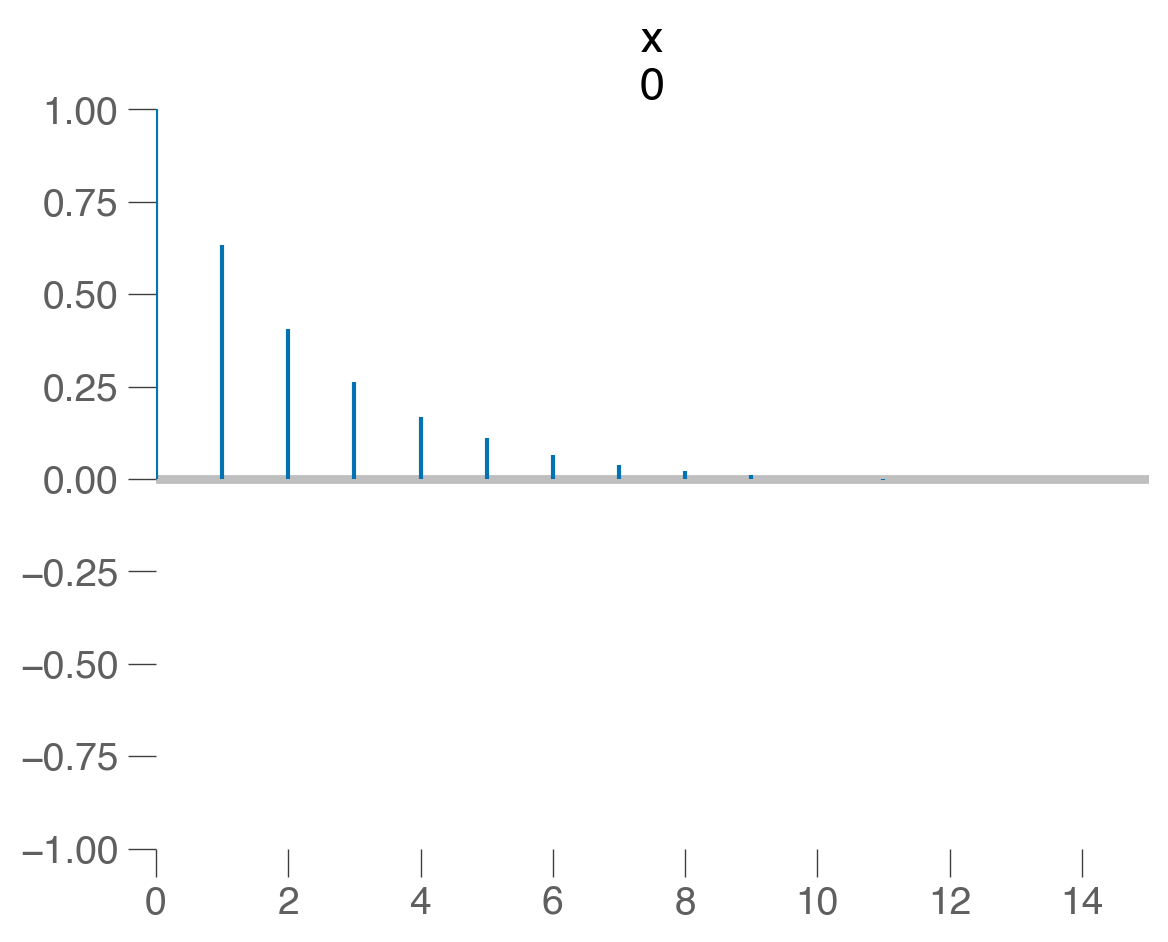

In [72]:
az.plot_autocorr(samps[40000::], max_lag=15)
plt.show()

Se applichiamo un "thinning" con un intervallo di 5, l'autocorrelazione si riduce quasi a zero.

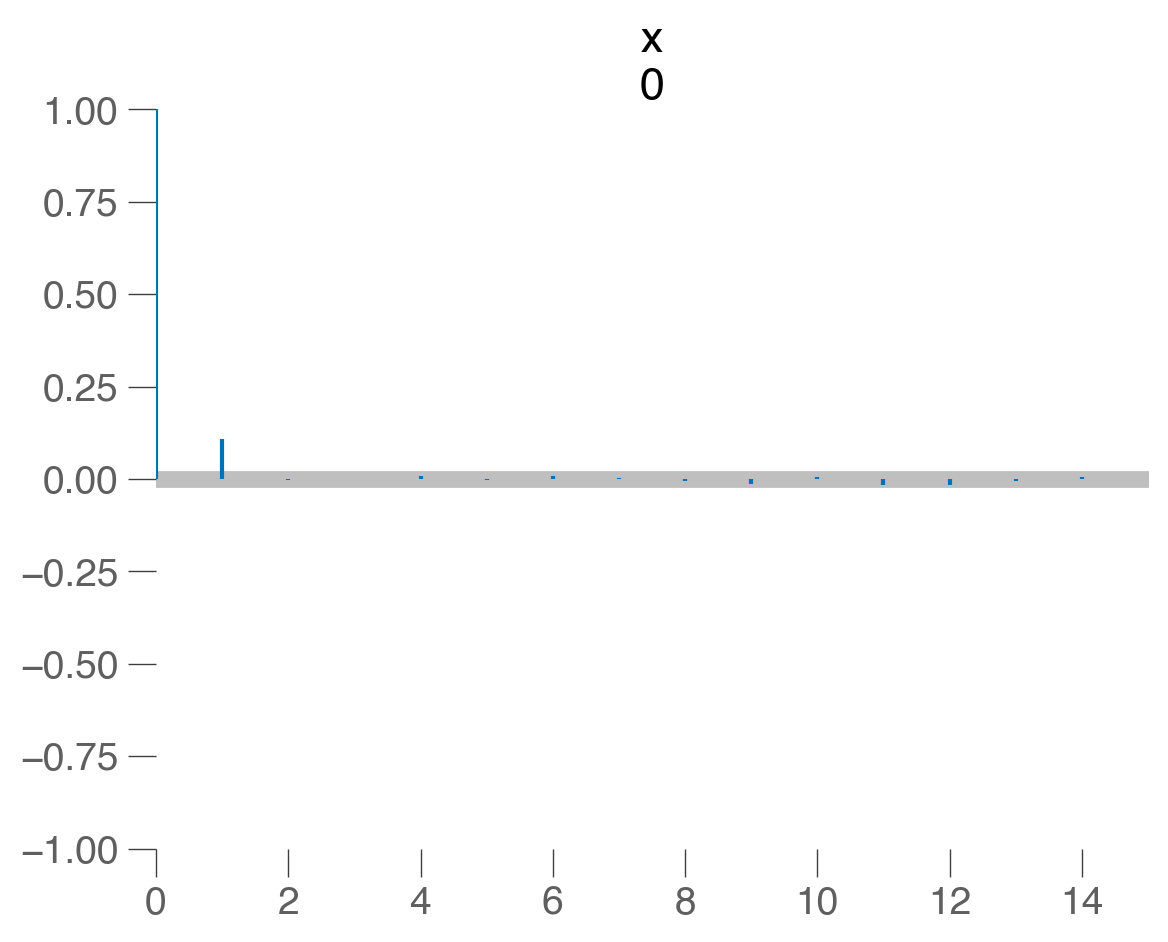

In [73]:
az.plot_autocorr(samps[40000::5], max_lag=15)
plt.show()

Esaminiamo la stima della distribuzione a posteriori dopo un burn-in di 40000 passi.

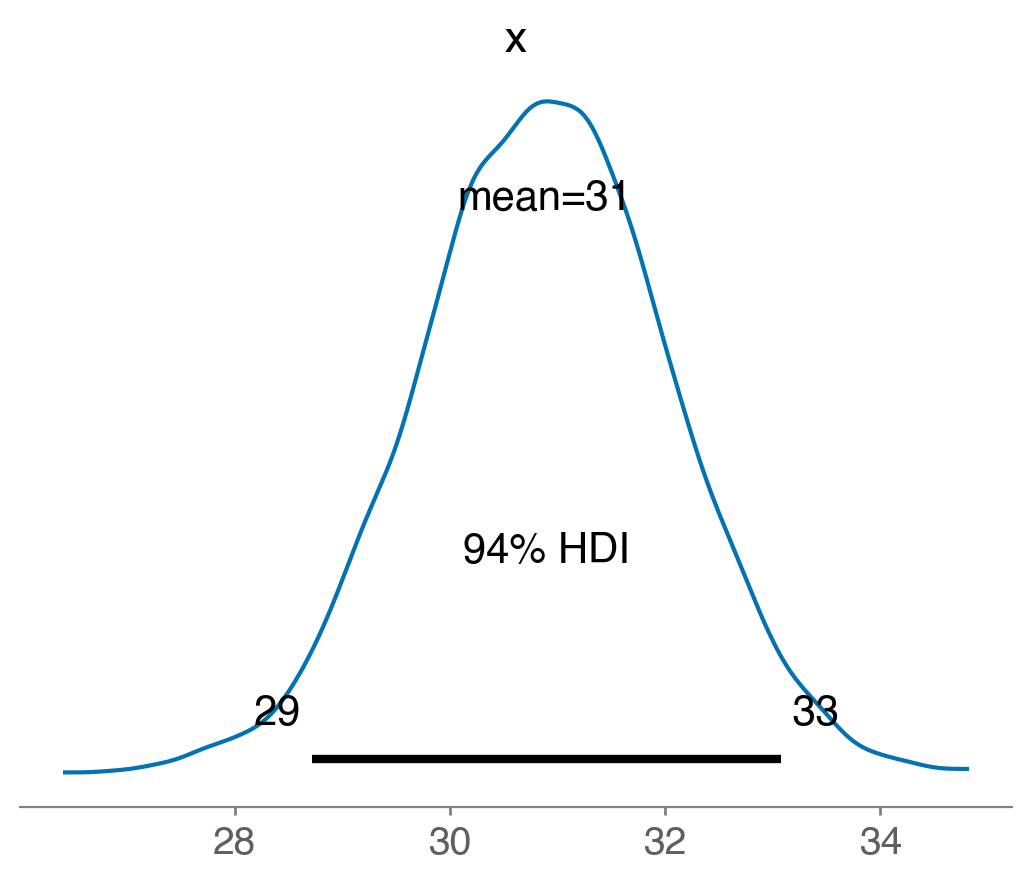

In [74]:
az.plot_posterior(samps[40000::5], hdi_prob=0.94)
plt.show()

Calcoliamo l'intervallo a densità posteriore più alta del 94% per il parametro $\mu$.

In [61]:
az.hdi(samps[40000::5], hdi_prob=0.94)

array([28.71639525, 33.08153582])

#### Campionamento con PyMC

Ripetiamo ora i calcoli precedenti usando PyMC. Di seguito è riportata la rappresentazione del modello in codice PyMC:

In [47]:
with pm.Model() as model:
    data = pm.ConstantData("data", df["y"])
    mu = pm.Normal("mu", mu=30, sigma=5)
    pm.Normal("y", mu=mu, sigma=np.std(df["y"]), observed=data)

Eseguiamo il campionamento MCMC.

In [48]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:04.895829
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 775.11it/s]

Sampling time =  0:00:03.215117
Transforming variables...
Transformation time =  0:00:00.004707


Esaminiamo la traccia (cioè il vettore dei campioni del parametro $\mu$ prodotti dalla procedura di campionamento MCMC) mediante un *trace plot* .

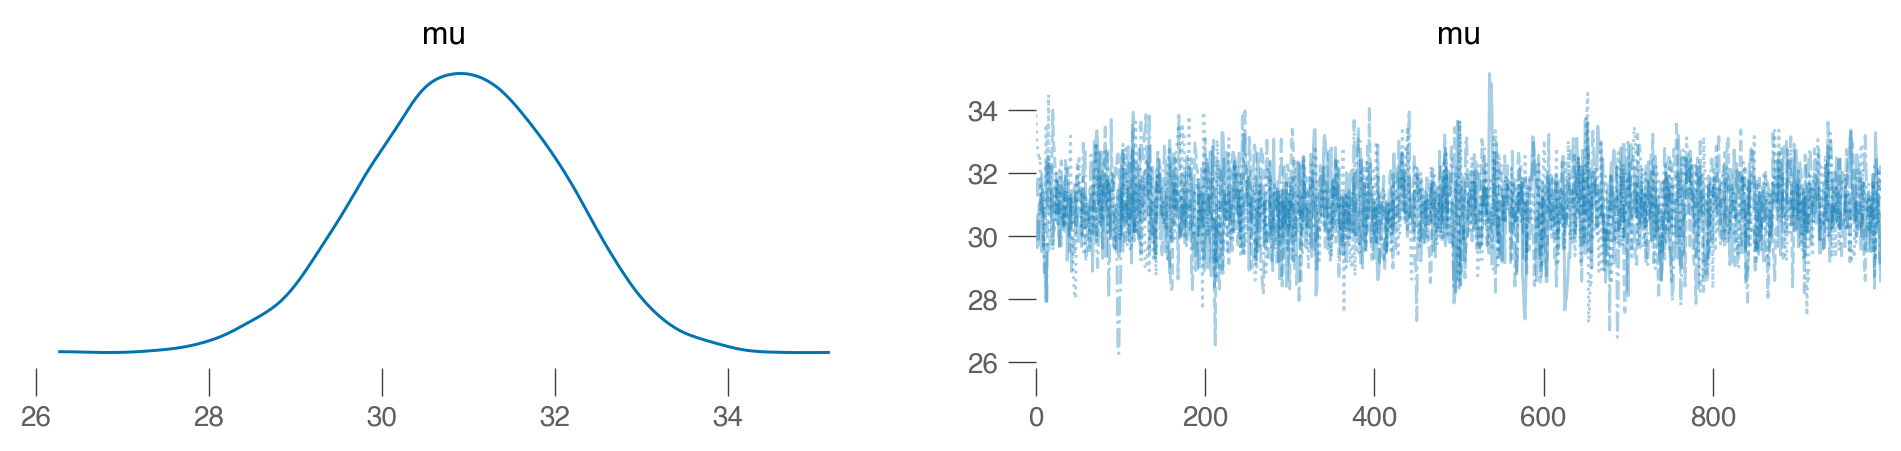

In [49]:
az.plot_trace(idata, combined=True)
plt.show()

Esaminiamo l'autocorrelazione.

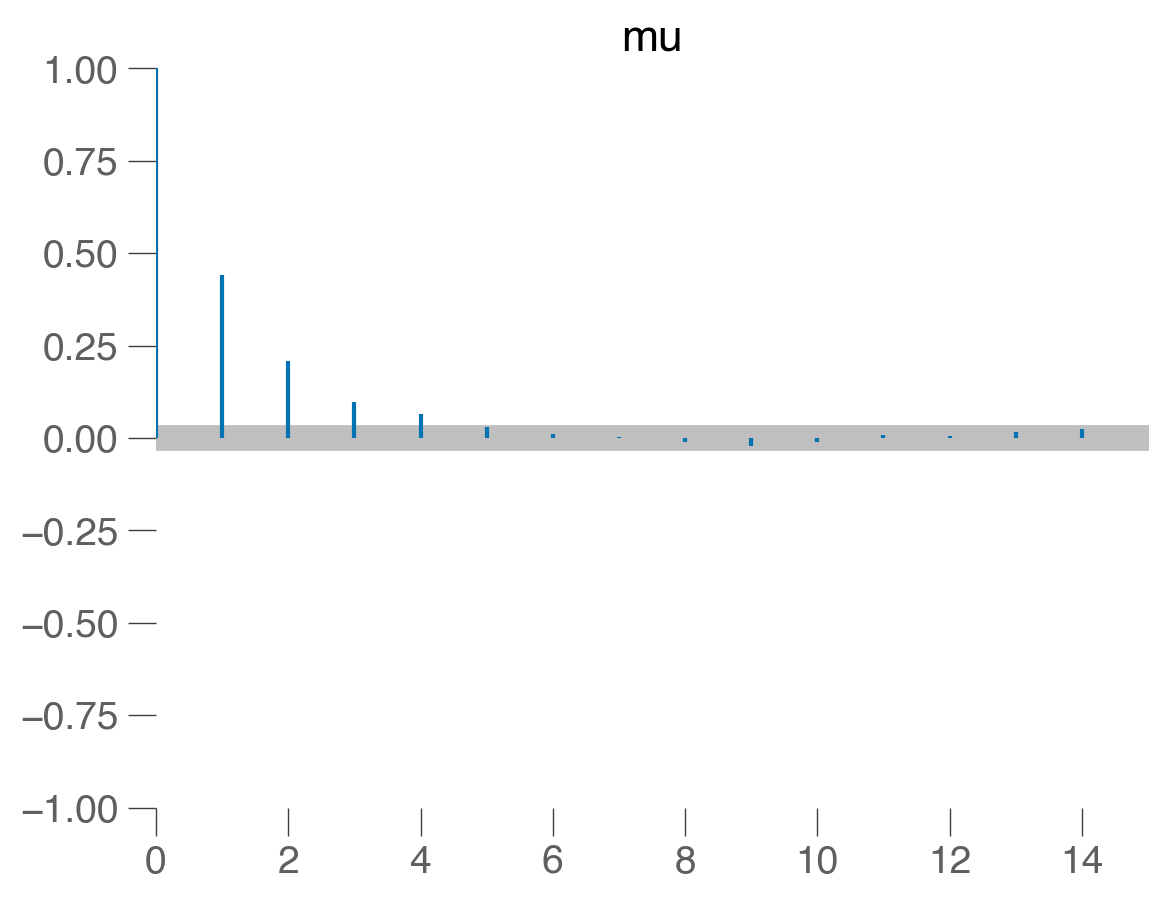

In [75]:
az.plot_autocorr(idata, combined=True, max_lag=15)
plt.show()

Una sintesi della distribuzione a posteriori dei parametri si ottiene nel modo seguente.

In [76]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,30.92,1.14,28.89,33.1,0.03,0.02,1459.16,1935.24,1.0


Si noti che la stima ottenuta per la media della popolazione corrisponde al valore teorico atteso fornito nel capitolo {ref}`distr-coniugate-2-notebook`, ovvero $\mu_p$ = 30.88. Il valore teorico di $\sigma_p$ è 1.15 e anch'esso è molto simile al valore ottenuto da PyMC.

Calcoliamo l'intervallo di credibilità a più alta densità a posteriori (HPD) al 94%.

In [77]:
az.hdi(idata, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 28.89 33.1

Le stime così trovate sono molto simili ai quantili di ordine 0.03 e 0.97 della distribuzione a posteriori di $\mu$ ottenuta per via analitica e a quelle ottenute con l'algoritmo di Metropolis che abbiamo implementato in precedenza.

In [78]:
stats.norm.ppf([0.03, 0.97], loc=30.8836, scale=1.1539)

array([28.71335226, 33.05384774])

### Versione 2 ($\sigma$ incognita)

È facile estendere il caso precedente alla situazione in cui il parametro $\sigma$ è incognito. Se non conosciamo $\sigma$, è necessario imporre su tale parametro una distribuzione a priori. Supponiamo di ipotizzare per $\sigma$ una distribuzione a priori $\text{HalfNormal}(10)$.

Mediante una HalfNormal(10) descriviamo il grado di credibilità soggettiva che attribuiamo ai possibili valori (\> 0) del parametro $\sigma$. Ai valori prossimi allo 0 attribuiamo la credibilità maggiore; la credibilità dei valori $\sigma > 0$ diminuisce progressivamente quando ci si allontana dallo 0, come indicato dalla curva della figura seguente. Riteniamo poco credibili i valori $\sigma$ maggiori di 15, anche se non escludiamo completamente che $\sigma$ possa assumere un valore in questo intervallo.

La $\text{HalfNormal}(10)$ è raffigurata nella figura seguente.

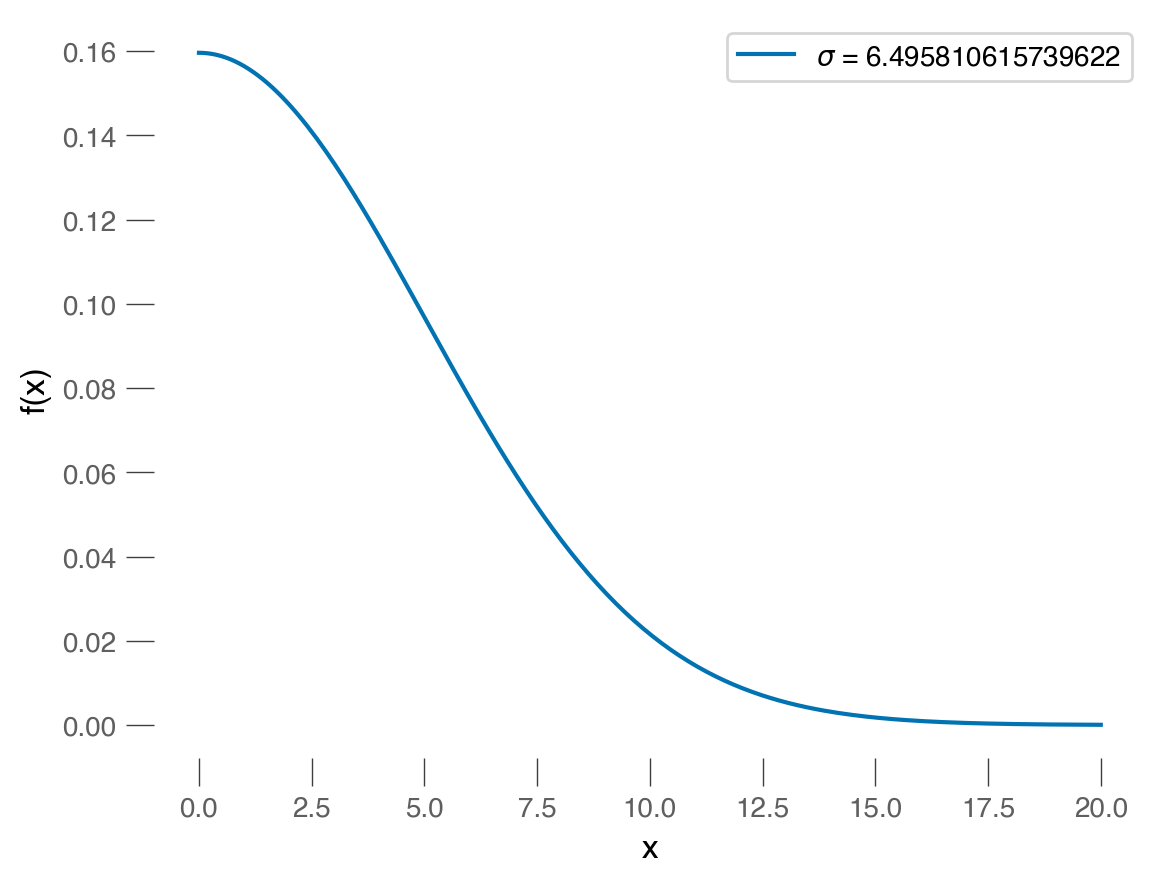

In [26]:
x = np.linspace(0, 20, 200)
pdf = stats.halfnorm.pdf(x, scale=5)
plt.plot(x, pdf, label=r'$\sigma$ = {}'.format(sigma))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In questo secondo scenario, più realistico, la struttura del modello è la seguente:

$$
\begin{align}
Y_i &\sim \mathcal{N}(\mu, \sigma) \notag\\
\mu &\sim \mathcal{N}(30, 5) \notag\\
\sigma &\sim \mathcal{N}(0, 10) \notag
\end{align}
$$

Questa formulazione è simile a quella esaminata precedentemente. Tuttavia, abbiamo espresso l'incertezza associata a $\sigma$ (che è incognito) attraverso una distribuzione a priori $\text{HalfNormal}$ con deviazione standard 10.

Di seguito è riportata la rappresentazione del modello in codice PyMC:

In [83]:
with pm.Model() as model2:
    data = pm.ConstantData("data", df["y"])
    mu = pm.Normal("mu", mu=30, sigma=5)
    sigma = pm.HalfNormal("sigma_prior", sigma=10)
    pm.Normal("y", mu=mu, sigma=sigma, observed=data)

Eseguiamo il campionamento.

In [84]:
with model2:
    idata2 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:01.110600
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 606.90it/s]

Sampling time =  0:00:03.466299
Transforming variables...
Transformation time =  0:00:00.027334


Esaminiamo la traccia con un *trace plot* .

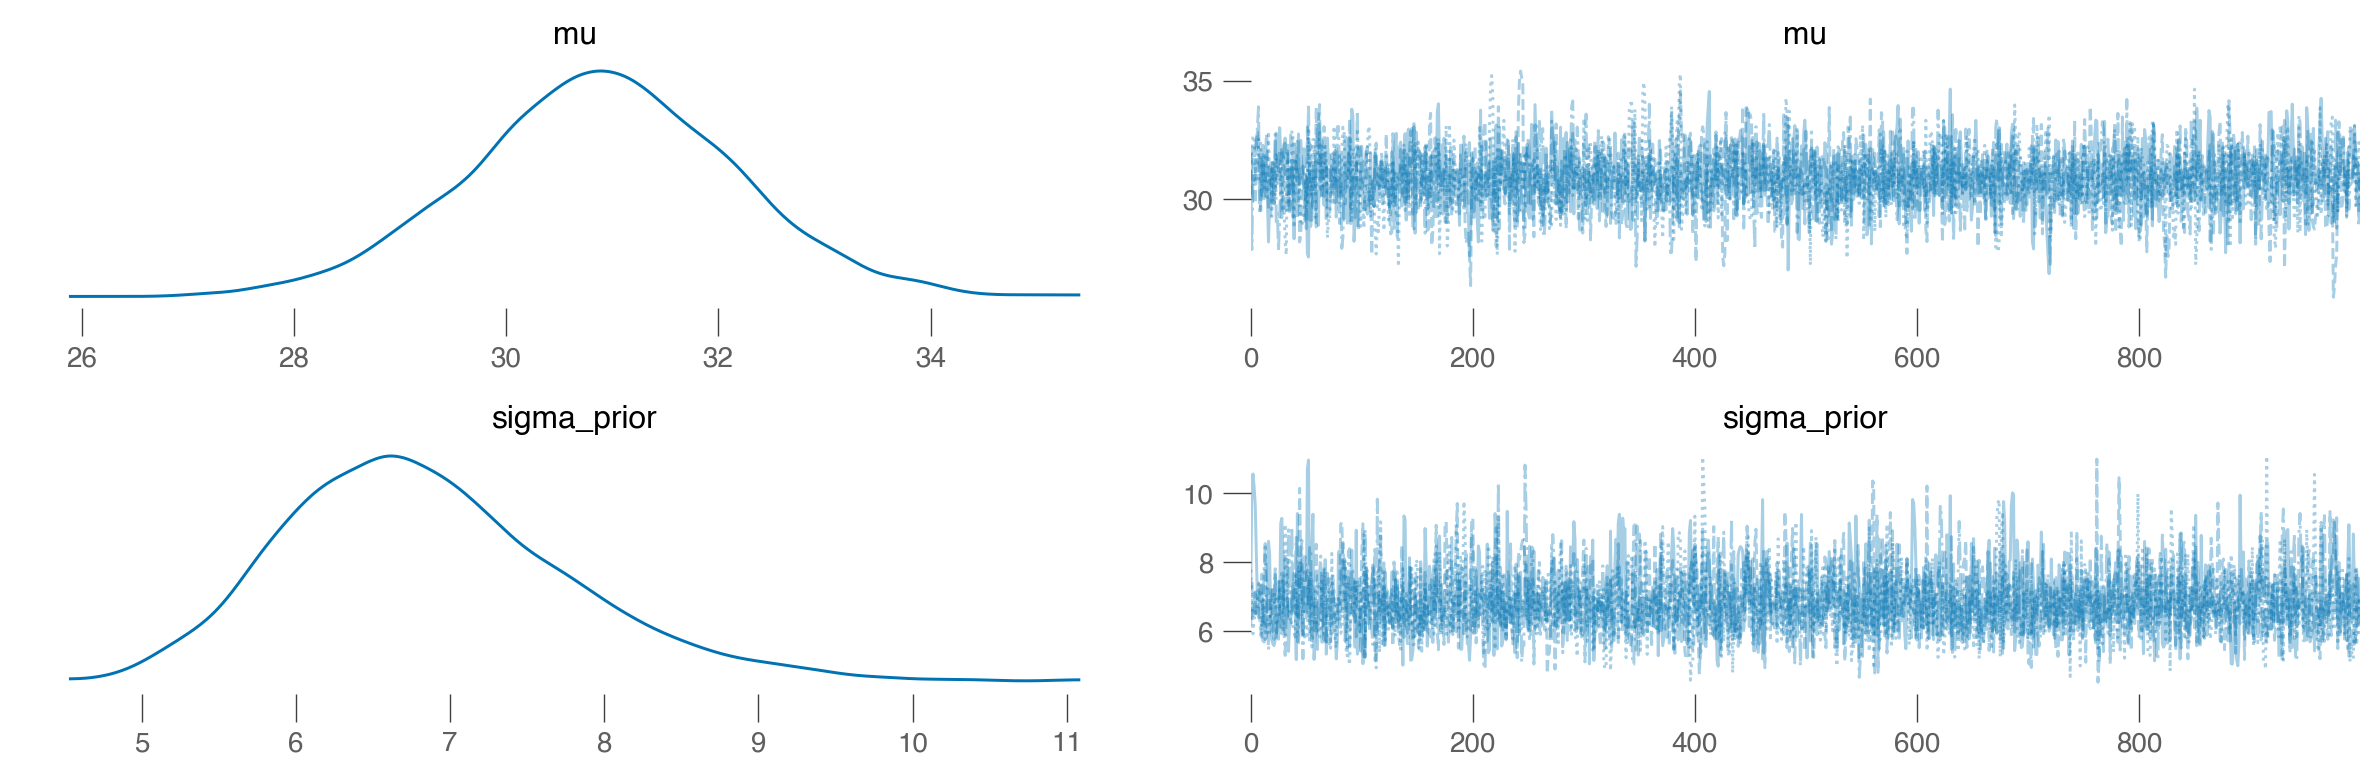

In [30]:
az.plot_trace(idata2, combined=True)
plt.tight_layout()
plt.show()

Una sintesi della distribuzione a posteriori dei parametri si ottiene nel modo seguente.

In [31]:
az.summary(idata2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,30.89,1.26,28.60,33.34,0.02,0.02,2810.26,2424.14,1.0
sigma_prior,6.86,0.94,5.15,8.58,0.02,0.01,3342.42,2628.95,1.0


Troviamo l'intervallo di credibilità a più alta densità a posteriori (HPD) al 94%.

In [32]:
az.hdi(idata2, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:      (hdi: 2)
Coordinates:
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    mu           (hdi) float64 28.6 33.34
    sigma_prior  (hdi) float64 5.147 8.578

I risultati sono molto simili a quelli ottenuti in precedenza.

## Commenti e considerazioni finali

In questo capitolo abbiamo visto come calcolare l'intervallo di credibilità per la media di una v.c. Normale usando PyMC. I risultati che abbiamo ottenuto corrispondono molto da vicino ai risultati che abbiamo ottenuto per via analitica nel capitolo {ref}`distr-coniugate-2-notebook`.

## Watermark

In [121]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Aug 07 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

pandas    : 2.0.3
pymc      : 5.7.1
scipy     : 1.11.1
seaborn   : 0.12.2
bambi     : 0.12.0
arviz     : 0.16.1
numpy     : 1.25.2
matplotlib: 3.7.1

Watermark: 2.4.3

